# Import and format data
## These  (until *) don't need to be run

In [ ]:
import pandas as pd
# names = ['Time','ID','Data']
read_file = pd.read_csv("candump-2021-02-08_150302.log", header = None)
read_file.to_csv (r'can_data.csv', index=None)
can_data = pd.read_csv("can_data.csv")

In [ ]:
can_data

### remove vcan0

In [ ]:
text = open("can_data.csv", "r")
text = ''.join([i for i in text]) \
    .replace("vcan0", ",")
x = open("can_data.csv","w")
x.writelines(text)
x.close()

### remove hash

In [ ]:
text = open("can_data.csv", "r")
text = ''.join([i for i in text]) \
    .replace("#", ",")
x = open("can_data.csv","w")
x.writelines(text)
x.close()

### remove parenthesis

In [ ]:
text = open("can_data.csv", "r")
text = ''.join([i for i in text]) \
    .replace("(", "")
x = open("can_data.csv","w")
x.writelines(text)
x.close()

text = open("can_data.csv", "r")
text = ''.join([i for i in text]) \
    .replace(")", "")
x = open("can_data.csv","w")
x.writelines(text)
x.close()

In [ ]:
can_data = pd.read_csv("can_data.csv",names = ['Time','ID','Data'])
can_data.to_csv (r'can_data.csv', index=None)
print(can_data)



# *

In [6]:
import pandas as pd
can_data = pd.read_csv("can_data.csv")
print(can_data)


                Time    ID              Data
0       0.000000e+00   NaN               NaN
1       1.612793e+09   039              0039
2       1.612793e+09   095  800007F400000017
3       1.612793e+09   1A4  0000000800000010
4       1.612793e+09   1AA  7FFF000000006711
...              ...   ...               ...
845498  1.612793e+09   244        00000001C0
845499  1.612793e+09   166          D0320018
845500  1.612793e+09   158  0000000000000019
845501  1.612793e+09   161  000005500108001C
845502  1.600000e+01   NaN               NaN

[845503 rows x 3 columns]


In [8]:
Time = can_data['Time']
Time = Time[1:-1]
Time = Time.reset_index(drop=True)

ID = can_data['ID']
ID = ID[1:-1]
ID = ID.reset_index(drop=True)

Data = can_data['Data']
Data = Data[1:-1]
Data = Data.reset_index(drop=True)




In [9]:
import numpy as np

def delta_time(Time): # calculates the time between two subsequent messages
    delta = np.zeros((Time.size))
    for x in range(Time.size-1):

       delta[x] = Time[x+1]-Time[x]

    return delta   

delta = delta_time(Time)


In [128]:
 def convert_from_hex(hex,output_type): # converts the data in hex from hexadecimal to decimal form
     out = np.zeros((hex.size))
     if output_type == 'dec':
        for x in range(hex.size):
            h_value = hex[x]
            out[x] = int(h_value,16)
     else:
        for x in range(hex.size):
            h_value = hex[x]
            binary[x] = bin(int(h_value, 16))[2:]

     return out


data = convert_from_hex(Data,'dec')
id = convert_from_hex(ID,'dec')

In [111]:
 def convert_to_bin(hex): # converts the data in hex from hexadecimal to decimal form
     binary = np.zeros((hex.size))

     for x in range(hex.size):
         h_value = hex[x]
         binary[x] = bin(int(h_value, 16))[2:]
     return binary


data = convert_from_hex(Data)
id = convert_to_bin(ID)

In [119]:
id[4]

110110000.0

## Normalize data

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data = data.reshape(-1, 1)
#data = scaler.fit_transform(data)
id = id.reshape(-1, 1)
id = scaler.fit_transform(id)

## Visualize data

Text(0, 0.5, 'ID')

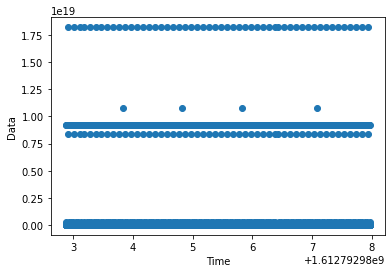

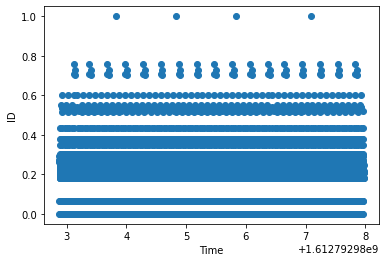

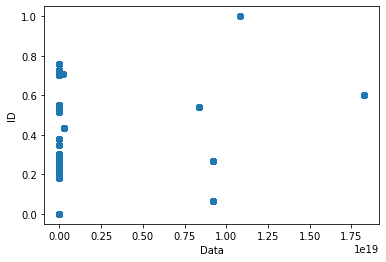

In [33]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(Time[0:10000],data[0:10000],'o')
plt.xlabel('Time')
plt.ylabel('Data')

plt.figure()
plt.plot(Time[0:10000],id[0:10000],'o')
plt.xlabel('Time')
plt.ylabel('ID')

plt.figure()
plt.plot(data[0:10000],id[0:10000],'o')
plt.xlabel('Data')
plt.ylabel('ID')




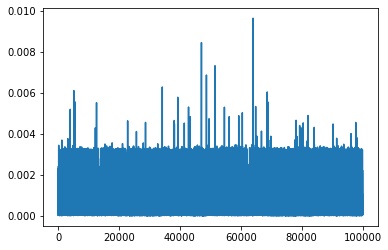

In [6]:
steps = range(Time.size)
plt.figure()
plt.plot(steps[0:100000],delta[0:100000])

In [34]:
def sort_IDs(id): # returns groups of indices of unique ids in list 

    idx_sort = np.argsort(id)
    sorted_ids = id[idx_sort]
    vals, idx_start, count = np.unique(sorted_ids, return_counts=True, return_index=True)
    indices = np.split(idx_sort, idx_start[1:])

    return indices





In [35]:
transposed_id = np.transpose(id) # not sure why it needs to be transposed but it doesn't work otherwise
indices = sort_IDs(transposed_id[0][:])




In [36]:
def get_data_stream(indices,data): # collects the unique ids with their respective data streams

    num_unique_ids = len(indices)
    all_ids = []
    for x in range(num_unique_ids):
         
         id_data = data[indices[x]]
         all_ids.append(id_data)

    return all_ids

all_id_data = get_data_stream(indices,data)  

In [37]:
 # combines each unique id with its data stream in a matrix where the ID is in the first row, and its data stream is (ordered)
 # in the column under it. (one column = ID: data1,data2,..). column length = max data length, if data doesn't fill upp all rows they are filled with nan. 
def combine_ids_data(indices,id,all_id_data):
    i = -1
    ids_and_data = np.ones((np.max([len(pi) for pi in all_id_data])+1,len(all_id_data)))*np.nan 

    for x in indices:
        i = i+ 1
        index = indices[i] 
        index = index[0] # only save first one in group
        ID = id[index]

        data_stream = all_id_data[i]
        data_stream = data_stream[:,0] 
        ids_and_data[0,i] = ID
        ids_and_data[1:len(data_stream)+1,i] = data_stream

    return ids_and_data

d = combine_ids_data(indices,id,all_id_data)

In [38]:

print(f'Number of individual IDs in the full sequence = {len(d[0,:])}')
print(f'Maximum number of data packets per ID = {np.max([len(pi) for pi in all_id_data])}')

Number of individual IDs in the full sequence = 36
Maximum number of data packets per ID = 43061


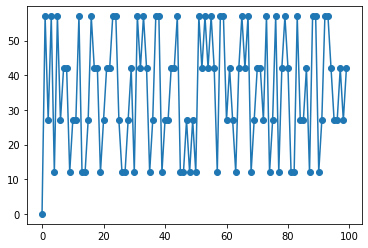

In [39]:
plt.plot(np.arange(100),d[0:100,0],'-o')

# Copied

In [46]:
# split a univariate sequence into samples
from numpy import array


def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [57]:
def remove_nans(input): # remove nans from data stream column
    input_nans = np.isnan(input) 
    not_nan = ~ input_nans
    clean_input = input[not_nan]
    return clean_input

In [58]:
from numpy import array


def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
		# find the end of this pattern
        end_ix = i + n_steps
        end_iy = end_ix + n_steps 
		# check if we are beyond the sequence
        if end_iy > len(sequence)-1:
            break
		# gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_iy]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [69]:
n_steps = 5
seq = remove_nans(d[:,0])   

nTrain = round(0.9*len(seq))
nTest = len(seq)-nTrain
xTrain = seq[0:nTrain]
xTest = seq[nTrain:len(seq)]

X_train, y_train = split_sequence(xTrain, n_steps)
X_test, y_test = split_sequence(xTest, n_steps)



In [79]:
y_test.shape

(2830, 5)

In [136]:
#! pip install tensorflow
#! pip install keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout


In [71]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

In [67]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [142]:

# define model (autoencoder)
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps,1)))
print(model.output_shape)
model.add(RepeatVector(n_steps))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')


(None, 100)


In [141]:
# canolo
model = Sequential()
model.add(Dense(256, activation='sigmoid', input_shape=(n_steps,1)))
model.add(Dropout(0.2, input_shape=(n_steps,1)))
print(model.output_shape)
#model.add(RepeatVector(n_steps))
model.add(LSTM(128, activation='relu'))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.compile(optimizer='adam', loss='mse')


(None, 5, 256)


ValueError: Input 0 of layer lstm_27 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 128]

In [ ]:
# fit model

model.fit(X, y, epochs=20, verbose=0)

Epoch 1/100
355/355 - 6s - loss: 0.0214 - val_loss: 0.0544
Epoch 2/100
355/355 - 6s - loss: 0.0282 - val_loss: 0.1123
Epoch 3/100
355/355 - 6s - loss: 0.0329 - val_loss: 0.1385
Epoch 4/100
355/355 - 6s - loss: 0.0307 - val_loss: 0.0292
Epoch 5/100
355/355 - 6s - loss: 0.0269 - val_loss: 0.0254
Epoch 6/100
355/355 - 7s - loss: 0.0355 - val_loss: 0.0777
Epoch 7/100
355/355 - 7s - loss: 0.0252 - val_loss: 0.0614
Epoch 8/100
355/355 - 7s - loss: 0.0232 - val_loss: 0.0329
Epoch 9/100
355/355 - 7s - loss: 0.0248 - val_loss: 0.0545
Epoch 10/100
355/355 - 7s - loss: 0.0222 - val_loss: 0.0465
Epoch 11/100
355/355 - 6s - loss: 0.0275 - val_loss: 0.0188
Epoch 12/100
355/355 - 7s - loss: 0.0280 - val_loss: 0.0448
Epoch 13/100
355/355 - 7s - loss: 0.0253 - val_loss: 0.0409
Epoch 14/100
355/355 - 6s - loss: 0.0250 - val_loss: 0.0720
Epoch 15/100
355/355 - 7s - loss: 0.0203 - val_loss: 0.0420
Epoch 16/100
355/355 - 6s - loss: 0.0253 - val_loss: 0.0758
Epoch 17/100
355/355 - 6s - loss: 0.0293 - val_lo

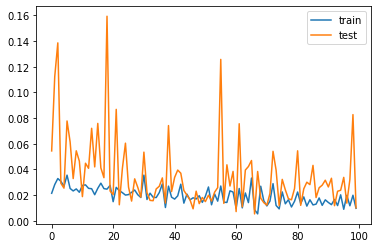

In [103]:
# design network
# fit network
history = model.fit(X_train, X_train, epochs=100, batch_size=72, validation_data=(X_test, X_test), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [108]:

# demonstrate prediction
x_input = array([1000,20,3,40,0])
x_input = x_input.reshape(1,5,1)
#print(x_input)
#x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)


[[[841.0436 ]
  [214.36266]
  [215.03436]
  [338.14737]
  [302.3861 ]]]


In [133]:
print( X[56,1,:]-yhat)
print( X[56,1,:])

IndexError: index 56 is out of bounds for axis 0 with size 1

In [ ]:
train_X = X
train_y = y
test_X = X[50:55,1,:]
test_y = X[56,1,:]
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import LSTM
# prepare sequence
length = 5
seq = array([i/float(length) for i in range(length)])
#X = seq.reshape(1, length, 1)
#y = seq.reshape(1, length, 1)
# define LSTM configuration
n_neurons = length
n_batch = 1
n_epoch = 1000
# create LSTM
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(length, 1), return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
# train LSTM
model.fit(X_train, y_train, epochs=n_epoch, batch_size=n_batch, verbose=2)
# evaluate
result = model.predict(X_test, batch_size=n_batch, verbose=0)
for value in result[0,:,0]:
 print('%.1f' % value)

## ^copied